# Initializations and Imports

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
! pip install nibabel
import nibabel as nib
import numpy as np
import os, glob
import psutil
import gc
import pandas as pd
import zipfile
from nibabel.processing import resample_from_to
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, clone

from io import BytesIO


mpl.rcParams.update({
    "font.family": "Liberation Sans",   # or "Liberation Sans"
    "pdf.fonttype": 42,             # Embed TrueType fonts
    "ps.fonttype": 42,              # Prevent outline fonts
    "text.usetex": False,
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "savefig.dpi": 300
})

In [4]:
# changes directory from colab to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Choose your base folder (local runtime or Drive)
BASE_DIR = "/content/drive/MyDrive/Capstone-Project/figures"

# Create it if it doesn't exist
os.makedirs(BASE_DIR, exist_ok=True)

print(f"Figures will be saved to: {BASE_DIR}")

Figures will be saved to: /content/drive/MyDrive/Capstone-Project/figures


# Import Tissue Volume CSV

In [6]:
in_roots    = ["/content/drive/MyDrive/Capstone-Project/derivatives/pp_preproc_anat"]
in_patterns = ["**/*_preproc.nii.gz", "**/*_preproc.nii"]

seg_out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_seg"

# Save volumes CSV
csv_path = os.path.join(seg_out_dir, "tissue_volumes_w_cluster_seg.csv")
df_tissue=pd.read_csv(csv_path)
print("Saved:", csv_path)

Saved: /content/drive/MyDrive/Capstone-Project/derivatives/pp_seg/tissue_volumes_w_cluster_seg.csv


# Supervised ML Classic Modeling

##  cluster → string labels → parcellation → features → PCA (min[20, 95% var], inside pipeline) → model comparison → final report

Saved labels CSV: /content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised/subjects_with_string_labels.csv
Label mapping (CSF desc): {3.0: 'AD', 2.0: 'MCI/AD', 1.0: 'MCI', 0.0: 'CN'}
Saved data-driven parcels: /content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised/parcels_k100.nii.gz | K = 100
Saved features CSV: /content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised/parcel_features_with_string_labels.csv
[EDA] PCA rule → retain 20 components (min[20, d95=29]). Explained variance = 0.92


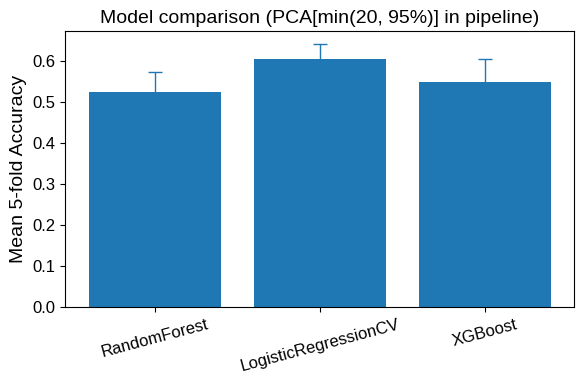


=== Cross-validated metrics (sorted by macro-F1) ===
               model  acc_mean  acc_std  bal_mean  f1_mean
LogisticRegressionCV     0.605    0.034     0.616    0.612
             XGBoost     0.548    0.056     0.542    0.535
        RandomForest     0.525    0.049     0.500    0.490

Training final LogisticRegressionCV on 80/20 split ...

=== Final Test Performance ===
              precision    recall  f1-score   support

          AD      0.667     0.571     0.615         7
          CN      0.625     1.000     0.769         5
         MCI      0.667     0.500     0.571         8
      MCI/AD      0.200     0.200     0.200         5

    accuracy                          0.560        25
   macro avg      0.540     0.568     0.539        25
weighted avg      0.565     0.560     0.549        25



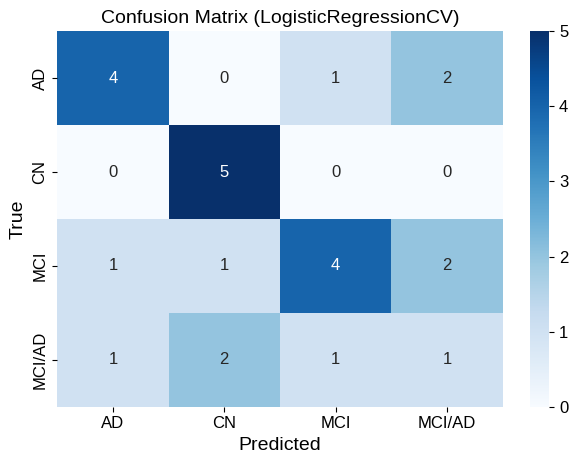

In [7]:
# ============================================================
#  FULL PIPELINE (leakage-safe, code aligned with write-up):
#  cluster → string labels → parcellation → features
#     → PCA (min[20, 95% var], inside pipeline) → model comparison → final report
# ============================================================

# ---- Optional: install xgboost if not available in your env ----
try:
    from xgboost import XGBClassifier
except Exception as _:
    try:
        get_ipython  # noqa
        get_ipython().system("pip -q install xgboost")
        from xgboost import XGBClassifier
    except Exception:
        # fallback stub (won't be used if import fails)
        class XGBClassifier:  # noqa
            def __init__(self, *a, **k): raise ImportError("xgboost not installed")

# ------------------------------------------------------------
# 0) Inputs & checks
# ------------------------------------------------------------
assert {"file","Cluster","GM_frac","WM_frac","CSF_frac"}.issubset(df_tissue.columns), \
    "df must contain: file, Cluster, GM_frac, WM_frac, CSF_frac"

out_dir = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised"
os.makedirs(out_dir, exist_ok=True)
subjects_csv = os.path.join(out_dir, "subjects_with_string_labels.csv")
parcels_nii  = os.path.join(out_dir, "parcels_k100.nii.gz")
parcel_feats_csv = os.path.join(out_dir, "parcel_features_with_string_labels.csv")

# ------------------------------------------------------------
# 1) Map numeric clusters → string labels by CSF fraction
#    Highest CSF → AD, then MCI/AD, then MCI, lowest CSF → CN
# ------------------------------------------------------------
def map_clusters_to_diagnoses(df_in, cluster_col="Cluster", csf_col="CSF_frac"):
    means = df_in.groupby(cluster_col)[csf_col].mean().sort_values(ascending=False)
    ordered_ids = means.index.tolist()  # descending CSF (higher CSF = more degeneration)
    if len(ordered_ids)==4:
      desired_names = ["AD", "MCI/AD", "MCI", "CN"]  # consistent label order
    elif len(ordered_ids)==3:
      desired_names = ["AD", "MCI", "CN"]  # consistent label order
    names = desired_names[:len(ordered_ids)]
    if len(ordered_ids) > len(desired_names):
        names += [f"Subtype-{i}" for i in range(len(desired_names), len(ordered_ids))]
    mapping = {cid: names[i] for i, cid in enumerate(ordered_ids)}
    out = df_in.copy()
    out["Cluster_Label"] = out[cluster_col].map(mapping)
    return out, mapping

df_tissue, label_map = map_clusters_to_diagnoses(df_tissue, cluster_col="Cluster", csf_col="CSF_frac")
df_tissue.to_csv(subjects_csv, index=False)
print("Saved labels CSV:", subjects_csv)
print("Label mapping (CSF desc):", label_map)

# ------------------------------------------------------------
# 2) Data-driven parcellation (reference = first subject volume)
#    - mask from top 95% intensities (p=5 threshold)
#    - KMeans on voxel coordinates → K parcels (≈100)
# ------------------------------------------------------------
def simple_mask_from_img(fp, p=5):
    img = nib.load(fp)
    arr = img.get_fdata(dtype=np.float32)
    finite = np.isfinite(arr)
    if not finite.any():
        raise ValueError("No finite voxels in image.")
    thr = np.percentile(arr[finite], p)
    m = finite & (arr > thr)
    return m.astype(bool), img

first_img_path = df_tissue["file"].iloc[0]
mask_bool, like_img = simple_mask_from_img(first_img_path, p=5)
ijk = np.argwhere(mask_bool)

n_parcels = 100
if len(ijk) < n_parcels:
    n_parcels = max(10, len(ijk)//50)
    print(f"[info] Reduced n_parcels to {n_parcels} due to mask size.")

km = KMeans(n_clusters=n_parcels, n_init=10, max_iter=500, random_state=42)
labels = km.fit_predict(ijk)

parcel_vol = np.zeros(mask_bool.shape, dtype=np.int32)
parcel_vol[mask_bool] = labels + 1  # 1..K, 0 background
parcel_img = nib.Nifti1Image(parcel_vol, like_img.affine, like_img.header)
nib.save(parcel_img, parcels_nii)
print("Saved data-driven parcels:", parcels_nii, "| K =", n_parcels)

# ------------------------------------------------------------
# 3) Feature extraction: parcel means + variances (resample-safe)
# ------------------------------------------------------------
def parcel_means_and_vars(img_path, par_img):
    """Resample subject to parcel grid if needed; return mean & var per parcel."""
    img = nib.load(img_path)

    shape_match = (img.shape[:3] == par_img.shape[:3])
    affine_match = np.allclose(img.affine, par_img.affine, atol=1e-3)
    if (not shape_match) or (not affine_match):
        img = resample_from_to(img, par_img, order=1)  # linear resample to parcel grid

    arr = img.get_fdata(dtype=np.float32)
    arr = np.nan_to_num(arr, nan=0.0)
    par = par_img.get_fdata().astype(np.int32)

    K = int(par.max())
    if K <= 0:
        return np.zeros(0, dtype=np.float32), np.zeros(0, dtype=np.float32)

    # Vectorized over parcels
    flat_vals = arr.reshape(-1)
    flat_lab  = par.reshape(-1)

    m_feats = np.zeros(K, np.float32)
    v_feats = np.zeros(K, np.float32)

    for k in range(1, K+1):
        idx = (flat_lab == k)
        if not np.any(idx):
            continue
        v = flat_vals[idx]
        if v.size:
            m_feats[k-1] = v.mean()
            v_feats[k-1] = v.var()
    return m_feats, v_feats

X_mean, X_var, y_str, keep_idx = [], [], [], []
for i, (fp, lab) in enumerate(zip(df_tissue["file"], df_tissue["Cluster_Label"])):
    try:
        m, v = parcel_means_and_vars(fp, parcel_img)
        if m.size == 0:
            print(f"[skip] Empty parcellation for: {fp}")
            continue
        X_mean.append(m); X_var.append(v); y_str.append(lab); keep_idx.append(i)
    except Exception as e:
        print(f"[skip] {e.__class__.__name__}: {fp} -> {e}")

if len(X_mean) == 0:
    raise RuntimeError("No subjects produced features. Check paths/masks/parcellation.")

X_mean = np.vstack(X_mean)    # (N, K_eff)
X_var  = np.vstack(X_var)     # (N, K_eff)
y      = np.array(y_str)      # string labels
df_used = df_tissue.iloc[keep_idx].reset_index(drop=True)

# Drop all-zero columns
valid_cols = (X_mean != 0).any(axis=0) | (X_var != 0).any(axis=0)
X_mean = X_mean[:, valid_cols]
X_var  = X_var[:, valid_cols]

# Append global GM/WM/CSF fractions
X_global = df_used[["GM_frac","WM_frac","CSF_frac"]].values.astype(np.float32)

# Final feature matrix = [parcel_means | parcel_vars | global fractions]
X_full = np.hstack([X_mean, X_var, X_global])

# Save the feature table with labels (optional)
feat_cols = (
    [f"ParcelMean_{i+1}" for i in range(X_mean.shape[1])] +
    [f"ParcelVar_{i+1}"  for i in range(X_var.shape[1])]  +
    ["GM_frac","WM_frac","CSF_frac"]
)
pd.concat([
    pd.DataFrame(X_full, columns=feat_cols),
    pd.Series(y, name="Label"),
    df_used[["file"]]
], axis=1).to_csv(parcel_feats_csv, index=False)
print("Saved features CSV:", parcel_feats_csv)

# ------------------------------------------------------------
# 4) PCA (min[20, 95% variance]) **inside** the pipeline (leakage-safe).
#    For EDA-only (not used by models): replicate the same rule on the full set.
# ------------------------------------------------------------
class PCA95or20(BaseEstimator, TransformerMixin):
    """
    Leakage-safe inside Pipeline: fits StandardScaler, then PCA with n_comp = min(20, d95).
    d95 is the smallest number of PCs whose cumulative explained variance ≥ 0.95.
    """
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler_ = None
        self.pca_ = None
        self.n_comp_ = None

    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X)
        Xs = self.scaler_.transform(X)
        # Fit full PCA once to compute d95
        pca_full = PCA(svd_solver="full", random_state=self.random_state).fit(Xs)
        cum = np.cumsum(pca_full.explained_variance_ratio_)
        d95 = int(np.searchsorted(cum, 0.95) + 1)
        self.n_comp_ = max(1, min(20, d95, Xs.shape[1]))
        self.pca_ = PCA(n_components=self.n_comp_, svd_solver="full", random_state=self.random_state).fit(Xs)
        return self

    def transform(self, X):
        Xs = self.scaler_.transform(X)
        return self.pca_.transform(Xs)

# EDA-only PCA summary (applies same rule globally; NOT used in modeling)
scaler_eda = StandardScaler().fit(X_full)
X_scaled_eda = scaler_eda.transform(X_full)
pca_full_eda = PCA(svd_solver="full", random_state=42).fit(X_scaled_eda)
cum_eda = np.cumsum(pca_full_eda.explained_variance_ratio_)
d95_eda = int(np.searchsorted(cum_eda, 0.95) + 1)
ncomp_eda = max(1, min(20, d95_eda, X_scaled_eda.shape[1]))
pca_eda = PCA(n_components=ncomp_eda, svd_solver="full", random_state=42).fit(X_scaled_eda)
print(f"[EDA] PCA rule → retain {ncomp_eda} components (min[20, d95={d95_eda}]). "
      f"Explained variance = {pca_eda.explained_variance_ratio_.sum():.2f}")

# ------------------------------------------------------------
# 5) Compare models with 5-fold CV (PCA95or20 inside pipeline)
# ------------------------------------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)  # e.g. ['AD', 'CN', 'MCI', 'MCI/AD'] depending on mapping order

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500, max_depth=None, class_weight="balanced",
        oob_score=True, bootstrap=True, random_state=42
    ),
    "LogisticRegressionCV": LogisticRegressionCV(
        Cs=10, cv=5, max_iter=2000, class_weight="balanced", n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="mlogloss",
        random_state=42
    ),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
cv_rows = []

for name, model in models.items():
    pipe = Pipeline([
        ("pca95or20", PCA95or20(random_state=42)),  # handles scaling internally
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_full, y_enc, cv=skf, n_jobs=-1)
    cv_results[name] = scores

    res = cross_validate(
        pipe, X_full, y_enc, cv=skf, n_jobs=-1,
        scoring={
            "acc": "accuracy",
            "bal_acc": make_scorer(balanced_accuracy_score),
            "macro_f1": make_scorer(f1_score, average="macro")
        }
    )
    cv_rows.append({
        "model": name,
        "acc_mean": res["test_acc"].mean(), "acc_std": res["test_acc"].std(),
        "bal_mean": res["test_bal_acc"].mean(),
        "f1_mean": res["test_macro_f1"].mean()
    })

# Quick accuracy plot
labels = list(cv_results.keys())
means  = [v.mean() for v in cv_results.values()]
stds   = [v.std()  for v in cv_results.values()]

x = np.arange(len(labels))
plt.figure(figsize=(6,4))
bars = plt.bar(x, means)
plt.errorbar(x, means, yerr=stds, fmt='none', capsize=5, linewidth=1)
plt.xticks(x, labels, rotation=15)
plt.ylabel("Mean 5-fold Accuracy")
plt.title("Model comparison (PCA[min(20, 95%)] in pipeline)")
plt.tight_layout()
plt.show()

# Richer metric table
cv_tbl = pd.DataFrame(cv_rows).sort_values("f1_mean", ascending=False)
print("\n=== Cross-validated metrics (sorted by macro-F1) ===")
print(cv_tbl.to_string(index=False, float_format=lambda z: f"{z:.3f}"))

# ------------------------------------------------------------
# 6) Train final best model on 80/20 split and report
#    (selected by accuracy mean, consistent with earlier logic)
# ------------------------------------------------------------
best_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_model = models[best_name]
print(f"\nTraining final {best_name} on 80/20 split ...")

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

pipe_final = Pipeline([
    ("pca95or20", PCA95or20(random_state=42)),
    ("clf", best_model)
])
pipe_final.fit(X_train, y_train)
y_pred_enc = pipe_final.predict(X_test)

# Map back to strings for readable report
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_enc)

print("\n=== Final Test Performance ===")
print(classification_report(y_test_str, y_pred_str, digits=3))
cm = confusion_matrix(y_test_str, y_pred_str, labels=class_names)  # class order consistent with encoder
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


# Full ML Pipeline - Summary, Create Report and Save Figs. as PDFs



In [8]:
# ============================================================
#  ML Summary-Only Pipeline (leakage-safe, publication-ready)
#  - Models: RandomForest, LogisticRegressionCV, XGBoost
#  - OOF predictions per model (5-fold Stratified CV)
#  - Saves PDF figs: ROC, PR (mean±SE), confusion matrices, bars (±95%CI),
#    expected-prob heatmap, permutation importance (top-k)
# ============================================================

# ---- Optional: install xgboost if needed ----
try:
    from xgboost import XGBClassifier
except Exception as _:
    try:
        get_ipython  # noqa
        get_ipython().system("pip -q install xgboost")
        from xgboost import XGBClassifier
    except Exception:
        class XGBClassifier:  # noqa
            def __init__(self, *a, **k): raise ImportError("xgboost not installed")

# =======================
# Style (journal)
# =======================
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 300,
    "pdf.fonttype": 42, "ps.fonttype": 42,
    "font.size": 9,
    "axes.labelsize": 9, "axes.titlesize": 10,
    "xtick.labelsize": 8, "ytick.labelsize": 8, "legend.fontsize": 8,
    "axes.linewidth": 0.8, "xtick.major.width": 0.8, "ytick.major.width": 0.8,
    "lines.linewidth": 1.2,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.autolayout": True,
})
sns.set_palette("colorblind")

# ============================================================
# 0) Inputs (expects df_tissue, X_full already built as in your code)
#    X_full = [parcel means | parcel vars | GM_frac | WM_frac | CSF_frac]
#    df_tissue['Cluster_Label'] holds string labels (CN/MCI/MCI-AD/AD)
# ============================================================
assert 'Cluster_Label' in df_tissue.columns, "df_tissue must contain Cluster_Label."
assert 'file' in df_tissue.columns, "df_tissue must contain file (for bookkeeping)."
assert isinstance(X_full, np.ndarray) and X_full.ndim == 2, "X_full must be 2D array."
y = df_tissue.loc[:, 'Cluster_Label'].to_numpy()
le = LabelEncoder(); y_enc = le.fit_transform(y)
CLASS_NAMES = list(le.classes_)
C = len(CLASS_NAMES)

# Output root
ROOT = "/content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised_ml_summary"
FIG_DIR = os.path.join(ROOT, "figs"); TAB_DIR = os.path.join(ROOT, "tables")
os.makedirs(FIG_DIR, exist_ok=True); os.makedirs(TAB_DIR, exist_ok=True)

# ============================================================
# 1) PCA transformer (inside pipeline; leakage-safe)
#    n_comp = min(20, d95%)
# ============================================================
class PCA95or20(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.scaler_ = None
        self.pca_ = None
        self.n_comp_ = None
    def fit(self, X, y=None):
        self.scaler_ = StandardScaler().fit(X)
        Xs = self.scaler_.transform(X)
        pca_full = PCA(svd_solver="full", random_state=self.random_state).fit(Xs)
        cum = np.cumsum(pca_full.explained_variance_ratio_)
        d95 = int(np.searchsorted(cum, 0.95) + 1)
        self.n_comp_ = max(1, min(20, d95, Xs.shape[1]))
        self.pca_ = PCA(n_components=self.n_comp_, svd_solver="full",
                        random_state=self.random_state).fit(Xs)
        return self
    def transform(self, X):
        Xs = self.scaler_.transform(X)
        return self.pca_.transform(Xs)

# ============================================================
# 2) Models to compare
# ============================================================
MODELS = {
    "RandomForest": RandomForestClassifier(
        n_estimators=500, max_depth=None, class_weight="balanced",
        oob_score=False, bootstrap=True, random_state=42
    ),
    "LogisticRegressionCV": LogisticRegressionCV(
        Cs=10, cv=5, max_iter=4000, class_weight="balanced", n_jobs=-1,
        multi_class="auto"
    ),
    "XGBoost": XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, eval_metric="mlogloss",
        random_state=42, n_jobs=-1
    ),
}

# ============================================================
# 3) CV runner that returns OOF probs, OOF preds, per-fold metrics
# ============================================================
def run_oof(model_name, model, X, y_enc, n_splits=5, seed=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    pipe = Pipeline([("pca95or20", PCA95or20(random_state=seed)), ("clf", model)])

    N, C = len(y_enc), len(np.unique(y_enc))
    oof_prob = np.zeros((N, C), dtype=np.float64)
    oof_pred = np.zeros(N, dtype=int)
    fold_metrics = []

    for f, (tr, te) in enumerate(skf.split(X, y_enc), 1):
        p = clone(pipe)
        p.fit(X[tr], y_enc[tr])

        # Probabilities & preds on the held-out fold
        P = p.predict_proba(X[te])
        yhat = P.argmax(1)

        oof_prob[te] = P
        oof_pred[te] = yhat

        # Fold metrics (for CI/SE)
        acc = accuracy_score(y_enc[te], yhat)
        bal = balanced_accuracy_score(y_enc[te], yhat)
        f1m = f1_score(y_enc[te], yhat, average="macro")
        fold_metrics.append({"fold": f, "acc": acc, "bal_acc": bal, "macro_f1": f1m})

    fold_df = pd.DataFrame(fold_metrics)
    return oof_prob, oof_pred, fold_df, pipe  # last pipe is the last-trained fold model

# ============================================================
# 4) Plot helpers (save as PDF)
# ============================================================
def save_pdf(fig, path):
    fig.savefig(path, bbox_inches="tight", pad_inches=0.02)
    plt.close(fig)

def plot_confusions(y_true, y_pred, labels, prefix):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    cmn = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
    # counts
    fig, ax = plt.subplots(figsize=(3.4, 3.0))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion (counts)")
    save_pdf(fig, os.path.join(FIG_DIR, f"{prefix}_cm_counts.pdf"))
    # row-normalized
    fig, ax = plt.subplots(figsize=(3.4, 3.0))
    sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=labels, yticklabels=labels, cbar=False, vmin=0, vmax=1, ax=ax)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title("Confusion (row-normalized)")
    save_pdf(fig, os.path.join(FIG_DIR, f"{prefix}_cm_norm.pdf"))

def plot_expected_prob_heatmap(y_true, oof_prob, labels, prefix):
    C = len(labels)
    M = np.zeros((C, C), float)
    for i in range(C):
        idx = (y_true == i)
        if idx.any(): M[i] = oof_prob[idx].mean(axis=0)
    fig, ax = plt.subplots(figsize=(3.4, 3.0))
    sns.heatmap(M, annot=True, fmt=".2f", cmap="Purples",
                xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cbar=False, ax=ax)
    ax.set_xlabel("Predicted class prob"); ax.set_ylabel("True class")
    ax.set_title("Expected P(class | true)")
    save_pdf(fig, os.path.join(FIG_DIR, f"{prefix}_expected_prob_heatmap.pdf"))

def plot_metric_bars(fold_df_dict, metric, title, fname):
    # mean ± 95% CI across folds
    rows = []
    for name, dfm in fold_df_dict.items():
        m = dfm[metric].mean()
        s = dfm[metric].std()
        ci = 1.96 * s / np.sqrt(len(dfm))
        rows.append({"model": name, "mean": m, "ci95": ci})
    tab = pd.DataFrame(rows).sort_values("mean", ascending=False)
    fig, ax = plt.subplots(figsize=(4.6, 3.0))
    x = np.arange(len(tab))
    ax.bar(x, tab["mean"].values, yerr=tab["ci95"].values, capsize=3, edgecolor="black")
    ax.set_xticks(x, tab["model"].tolist(), rotation=0)
    ax.set_ylim(0, 1)
    ax.set_ylabel(metric.replace("_", " ").title())
    ax.set_title(title)
    for i, m in enumerate(tab["mean"].values):
        ax.text(i, min(0.98, m+0.02), f"{m:.2f}", ha="center", va="bottom", fontsize=8)
    save_pdf(fig, os.path.join(FIG_DIR, fname))
    tab.to_csv(os.path.join(TAB_DIR, fname.replace(".pdf", ".csv")), index=False)

def _aggregate_curve_with_se(x_grid, xs, ys):
    """
    Interpolate fold curves onto a common x_grid and return mean ± SE of y.
    xs, ys are lists of per-fold arrays (same class).
    """
    Y = []
    for xf, yf in zip(xs, ys):
        # ensure monotonic x
        order = np.argsort(xf)
        xf, yf = xf[order], yf[order]
        # unique x for interpolation
        uniq, idx = np.unique(xf, return_index=True)
        yf = yf[idx]; xf = uniq
        # clip grid within the fold's domain
        mask = (x_grid >= xf.min()) & (x_grid <= xf.max())
        y_interp = np.interp(x_grid[mask], xf, yf)
        y_full = np.full_like(x_grid, np.nan, dtype=float)
        y_full[mask] = y_interp
        Y.append(y_full)
    Y = np.vstack(Y)  # (folds, len(grid))
    mean = np.nanmean(Y, axis=0)
    se   = np.nanstd(Y, axis=0) / np.sqrt(np.sum(~np.isnan(Y), axis=0).clip(min=1))
    return mean, se

def plot_roc_pr_mean_se(y_true, oof_prob, labels, cv_folds_indices, prefix):
    """
    y_true: array of ints (global order)
    oof_prob: (N, C) OOF probabilities (already in global order)
    cv_folds_indices: list of index arrays for each fold's test set (global indices)
    """
    C = len(labels)

    # --- ROC with mean±SE per class ---
    fig, ax = plt.subplots(figsize=(4.2, 3.2))
    xg = np.linspace(0, 1, 400)  # FPR grid
    for c in range(C):
        # per-fold storage
        fprs, tprs, aucs = [], [], []
        for te_idx in cv_folds_indices:
            y_bin = (y_true[te_idx] == c).astype(int)
            p_bin = oof_prob[te_idx, c]
            fpr, tpr, _ = roc_curve(y_bin, p_bin)
            fprs.append(fpr); tprs.append(tpr)
            aucs.append(auc(fpr, tpr))
        mean_tpr, se_tpr = _aggregate_curve_with_se(xg, fprs, tprs)
        mAUC = np.nanmean(aucs)
        ax.plot(xg, mean_tpr, label=f"{labels[c]} (AUC={mAUC:.2f})")
        ax.fill_between(xg, np.maximum(0, mean_tpr - se_tpr), np.minimum(1, mean_tpr + se_tpr),
                        alpha=0.15)
    ax.plot([0,1], [0,1], linestyle="--", color="gray", linewidth=0.8)
    ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC (mean ± SE across folds)")
    ax.legend(frameon=False, fontsize=7, ncol=2)
    save_pdf(fig, os.path.join(FIG_DIR, f"{prefix}_roc_meanSE.pdf"))

    # --- PR with mean±SE per class ---
    fig, ax = plt.subplots(figsize=(4.2, 3.2))
    xr = np.linspace(0, 1, 400)  # Recall grid
    for c in range(C):
        recs, precs, aps = [], [], []
        for te_idx in cv_folds_indices:
            y_bin = (y_true[te_idx] == c).astype(int)
            p_bin = oof_prob[te_idx, c]
            prec, rec, _ = precision_recall_curve(y_bin, p_bin)
            recs.append(rec); precs.append(prec)
            aps.append(average_precision_score(y_bin, p_bin))
        mean_prec, se_prec = _aggregate_curve_with_se(xr, recs, precs)
        mAP = np.nanmean(aps)
        ax.plot(xr, mean_prec, label=f"{labels[c]} (AP={mAP:.2f})")
        ax.fill_between(xr, np.maximum(0, mean_prec - se_prec), np.minimum(1, mean_prec + se_prec),
                        alpha=0.15)
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall (mean ± SE across folds)")
    ax.legend(frameon=False, fontsize=7, ncol=2)
    save_pdf(fig, os.path.join(FIG_DIR, f"{prefix}_pr_meanSE.pdf"))

# ============================================================
# 5) Run OOF for each model, collect folds, plot & save
# ============================================================
ALL = {}
cv_folds_indices_template = []  # to share folds layout per model plots
skf_global = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for _, te in skf_global.split(X_full, y_enc):
    cv_folds_indices_template.append(te)  # fixed folds for plotting SE

for name, model in MODELS.items():
    print(f"\n=== {name} : OOF evaluation ===")
    oof_prob, oof_pred, fold_df, last_pipe = run_oof(name, model, X_full, y_enc, n_splits=5, seed=42)
    ALL[name] = {"prob": oof_prob, "pred": oof_pred, "fold_df": fold_df, "pipe": last_pipe}

    # Save confusion matrices
    plot_confusions(y_enc, oof_pred, CLASS_NAMES, prefix=f"{name}_oof")

    # Expected probability heatmap
    plot_expected_prob_heatmap(y_enc, oof_prob, CLASS_NAMES, prefix=f"{name}_oof")

    # ROC / PR curves (mean±SE across the fixed folds template)
    plot_roc_pr_mean_se(y_enc, oof_prob, CLASS_NAMES, cv_folds_indices_template,
                        prefix=f"{name}_oof")

    # Save fold metrics table
    fold_df.to_csv(os.path.join(TAB_DIR, f"{name}_fold_metrics.csv"), index=False)

# ============================================================
# 6) Comparison bars across models (accuracy, macro-F1)
# ============================================================
fold_metrics = {name: ALL[name]["fold_df"] for name in MODELS.keys()}
plot_metric_bars(fold_metrics, metric="acc",
                 title="Accuracy (mean ± 95% CI) — 5-fold OOF",
                 fname="comparison_accuracy_bars.pdf")
plot_metric_bars(fold_metrics, metric="macro_f1",
                 title="Macro-F1 (mean ± 95% CI) — 5-fold OOF",
                 fname="comparison_macrof1_bars.pdf")

# Also export a combined CSV of model-wise means
rows = []
for name, dfm in fold_metrics.items():
    rows.append({
        "model": name,
        "acc_mean": dfm["acc"].mean(), "acc_sd": dfm["acc"].std(),
        "balacc_mean": dfm["bal_acc"].mean(), "balacc_sd": dfm["bal_acc"].std(),
        "f1_mean": dfm["macro_f1"].mean(), "f1_sd": dfm["macro_f1"].std(),
    })
cmp_df = pd.DataFrame(rows)
cmp_df.to_csv(os.path.join(TAB_DIR, "model_comparison_oof_metrics.csv"), index=False)

# ============================================================
# 7) Model-agnostic interpretability (Permutation Importance)
#    - Done on a stratified train/test split to avoid leakage
#    - Uses the full pipeline (scaler+PCA+model)
# ============================================================
X_tr, X_te, y_tr, y_te = train_test_split(
    X_full, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

def plot_permutation_importance(name, pipe, X_te, y_te, topk=20):
    # Permutation over the pipeline input space (pre-PCA)
    r = permutation_importance(
        pipe, X_te, y_te, n_repeats=20, random_state=42, scoring="f1_macro", n_jobs=-1
    )
    imp = pd.DataFrame({
        "feature_idx": np.arange(X_te.shape[1]),
        "importance_mean": r.importances_mean,
        "importance_sd": r.importances_std
    }).sort_values("importance_mean", ascending=False).head(topk)
    fig, ax = plt.subplots(figsize=(5.0, max(2.0, 0.25*len(imp))))
    ax.barh(range(len(imp)), imp["importance_mean"].values, xerr=imp["importance_sd"].values,
            capsize=2, edgecolor="black")
    ax.set_yticks(range(len(imp)))
    ax.set_yticklabels([f"x{int(i)}" for i in imp["feature_idx"].values])
    ax.invert_yaxis()
    ax.set_xlabel("Permutation importance (mean ± SD)")
    ax.set_title(f"{name}: Top-{len(imp)} features (pipeline-level)")
    save_pdf(fig, os.path.join(FIG_DIR, f"{name}_perm_importance_top{len(imp)}.pdf"))
    imp.to_csv(os.path.join(TAB_DIR, f"{name}_perm_importance_top{len(imp)}.csv"), index=False)

# Fit each model on train, run permutation importance on pipeline
for name, model in MODELS.items():
    p = Pipeline([("pca95or20", PCA95or20(random_state=42)), ("clf", clone(model))])
    p.fit(X_tr, y_tr)
    plot_permutation_importance(name, p, X_te, y_te, topk=20)

print("\nSaved figures to:", FIG_DIR)
print("Saved tables  to:", TAB_DIR)



=== RandomForest : OOF evaluation ===

=== LogisticRegressionCV : OOF evaluation ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


=== XGBoost : OOF evaluation ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1908: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Saved figures to: /content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised_ml_summary/figs
Saved tables  to: /content/drive/MyDrive/Capstone-Project/derivatives/pp_supervised_ml_summary/tables
